## Quantifying membrane concentrations

This notebook demonstrates the code used to perform quantification of PAR protein membrane concentrations.

### Instructions

To run all code and open interactive figures, click Run > Run All Cells. Figures will appear when the entire script has finished running.

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_polyroi import ROI_jupyter
from par_segmentation import load_image, straighten
from par_segmentation.quantifier import ImageQuant
from scipy.optimize import differential_evolution
from scipy.special import erf

%matplotlib widget

### Import image to quantify

Use the load_image function to import an image (tif format) as a 2D numpy array

In [2]:
# Path to image folder
path = "../data/Example_embryo_par6_mNG_par2_mCh"

# Path to autofluorescence-corrected green channel image
path_g = path + "/af_corrected.tif"

# Path to red channel image
path_r = path + "/NEBD_Control-RNAi_02_w33-561 SP 630-75 Nelio.TIF"

# Load image
img = load_image(path_g)
# img = load_image(path_r) ## <- uncomment this line to perform quantification on red channel image instead

#### View image

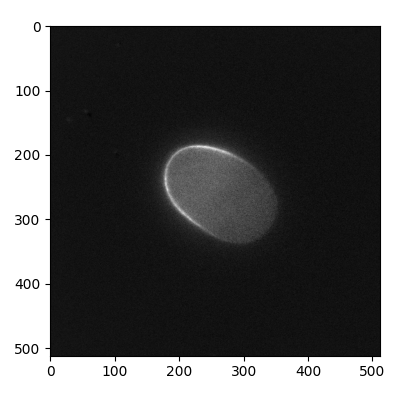

In [3]:
fig, ax = plt.subplots()
ax.imshow(img, cmap="gray")
fig.set_size_inches(4, 4)
fig.tight_layout()

### Specify ROI

Manually defining an initial ROI around the cortex, starting from the posterior. This does not need to be precise, as it will be refined by the quantifier.

You can import a pre-defined ROI (saved as a txt file), or maunally define one here (see below)

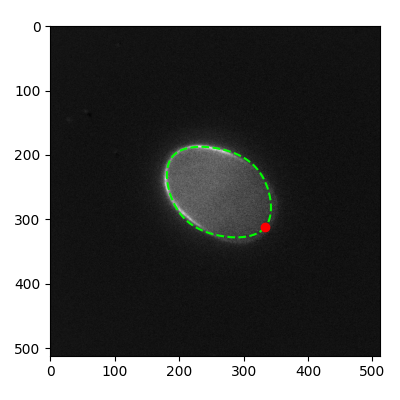

In [4]:
roi = np.loadtxt(path + "/ROI.txt")  # loading pre-defined ROI

fig, ax = plt.subplots()
ax.imshow(img, cmap="gray")
ax.plot(roi[:, 0], roi[:, 1], c="lime", linestyle="--")
ax.scatter(roi[0, 0], roi[0, 1], c="r", zorder=10)
fig.set_size_inches(4, 4)
fig.tight_layout()

To manually select an ROI, uncomment the next two cells, run the first cell, lay down points and click save. Then run the second cell.

In [5]:
# roi = None
# roi_tool = ROI_jupyter(img, spline=True, show_fit=True)
# roi_tool.run()

In [6]:
# roi = roi_tool.roi
# print(roi) # If this prints None, you might have forgotten to press Save above!

### Straighten cortex

The first step is to straighten the cortex. This can be done using the straighten function found in the par-segmentation package

In [7]:
straight = straighten(img, roi, 50)

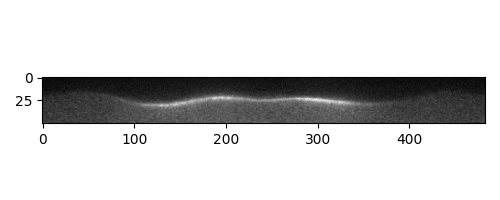

In [8]:
fig, ax = plt.subplots()
ax.imshow(straight, cmap="gray")
fig.set_size_inches(5, 2)
fig.tight_layout()

### Fit cross-cortex profile

To estimate membrane concentrations at each position around the cortex, cross-cortex profiles can be fit to a model described as the sum of a Gaussian function (representing membrane signal) and an error function (representing cytoplasmic signal). Membrane concentrations can then be taken as the amplitude of the Gaussian component. This procedure is demonstrated here for a single cross-cortex profile.

Fitting will be performed using the `differential_evolution` function from scipy (see documentation below)

In [9]:
# help(differential_evolution)

In [10]:
position = 300  ### <- specify position to fit
profile = straight[:, position]  # extract cross-cortex profile at that position
sigma = 2  ### <- width of Gaussian and error functions. Must be set manually by observing fits


# Gaussian function
def gaus(x, centre, width=sigma):
    return np.exp(-((x - centre) ** 2) / (2 * width**2))


# Error function
def error_func(x, centre, width=sigma):
    return 1 + erf((x - centre) / width)


# Model: Gaussian + error function
def model_profile(l, c, m, b):
    """
    l: centre of Gaussian and error functions (represents position of the cortex)
    c: amplitide of cytoplasmic (error function) component
    m: amplitude of membrane (Gaussian) component
    b: background intensity

    """
    x = np.arange(len(profile))
    y = m * gaus(x, l) + c * error_func(x, l) + b
    return y


# Loss function to optimise
def loss(l_c_m_b, profile):
    l, c, m, b = l_c_m_b
    y = model_profile(l, c, m, b)
    return np.mean((profile - y) ** 2)


# Bounds for parameters ((min, max) for each parameter)
bounds = (
    (10, 40),
    (-0.2 * max(profile), 2 * max(profile)),
    (-0.2 * max(profile), 2 * max(profile)),
    (-0.2 * max(profile), 2 * max(profile)),
)

# Perform optimisation
res = differential_evolution(loss, bounds=bounds, args=(profile,), tol=0.2)
print("Cytoplasmic intensity = %.2f" % res.x[1])
print("Membrane intensity = %.2f" % res.x[2])

Cytoplasmic intensity = 1505.81
Membrane intensity = 7997.48


#### Compare model fit and actual profile

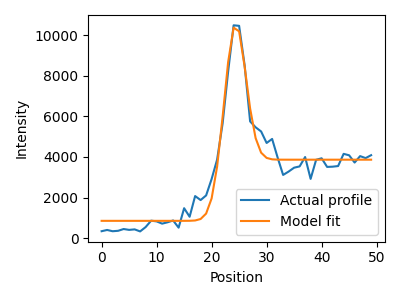

In [11]:
fig, ax = plt.subplots()
ax.plot(profile, label="Actual profile")
ax.plot(model_profile(*res.x), label="Model fit")
ax.set_xlabel("Position")
ax.set_ylabel("Intensity")
ax.legend()

fig.set_size_inches(4, 3)
fig.tight_layout()

### Quantify whole embryo with ImageQuant class

To perform membrane quantification around the whole embryo, we can use the `ImageQuant` class. This fits each position around the cortex using a procedure similar to above. These fits are then used to refine the initial ROI and restraighten the cortex, and fitting is then repeated. 

For more details, see the `par-segmentation` package on [GitHub](https://github.com/goehringlab/par-segmentation), or run the help command below:

In [12]:
# help(ImageQuant)

#### Perform fitting

Perform quantification using the `ImageQuant` class. This will save quantification results in the folder specified below (`save_path`).



In [13]:
# Specify path to save results
save_path = path + "/Quantification"

# Set up class
q = ImageQuant(
    img=img,
    roi=roi,
    sigma=2,
    thickness=50,
    rol_ave=20,
    parallel=False,
    freedom=15,
    nfits=100,
    bg_subtract=True,
    zerocap=True,
    iterations=2,
    method="DE",
)

# Run quantification
q.run()

# Save
q.save(save_path)
q.compile_res().to_csv(save_path + "/Quantification.csv", index=False)

Quantifying image 1 of 1
Time elapsed: 8.72 seconds 


#### Monitor quality of the fits

The interactive figure below shows the straightened cortex after refining the ROI, along with cross-cortex profiles and model fits at each position. It is a good idea to scan along the straightened cortex and compare the actual cross-cortex profiles to model fits, to make sure that the fits looks reasonable.

interactive(children=(FloatSlider(value=0.1, description='Position', max=1.0, step=0.01), Output()), _dom_clas…

(<Figure size 500x300 with 2 Axes>,
 (<Axes: xlabel='Position'>, <Axes: ylabel='Intensity'>))

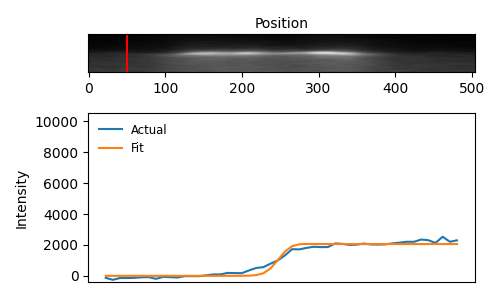

In [14]:
q.plot_fits()

#### Plot quantification results

Plot membrane concentration around the circumference of the embryo, from posterior to anterior, back to posterior. 

(Note: due to randomness in the optimisation algorithm, the results may look slightly different every time)

(<Figure size 500x300 with 1 Axes>,
 <Axes: xlabel='Position', ylabel='Membrane concentration'>)

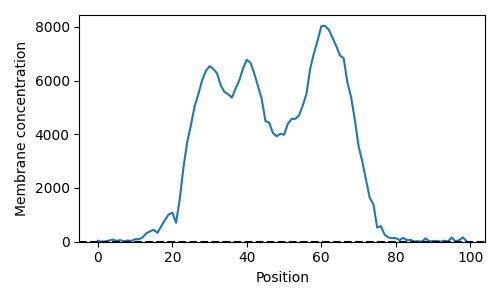

In [15]:
q.plot_quantification()